## import necessary libraries

In [4]:
import numpy as np 
import gym
import matplotlib.pyplot as plt
from collections import defaultdict


## set envoironment

In [2]:
blackjack_env=gym.make('Blackjack-v1')
''' actions:
stick (stop receiving card): 0
draw (take another card): 1
'''
'''states: (sum of your cards , dealer card , usable ace)'''
blackjack_env.reset()


C:\Users\ramin\anaconda3\envs\ramin\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\ramin\anaconda3\envs\ramin\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


(18, 3, False)

In [20]:
blackjack_env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

## policy function

In [21]:
'''selected policy to evaluate is stick if your card summation is >=18
and draw otherwise'''
def policy_func(obsertation):
    sum_of_cards,_,_=obsertation
    if sum_of_cards>=19:
        return 0
    else :
        return 1


## monte-carlo prediction 

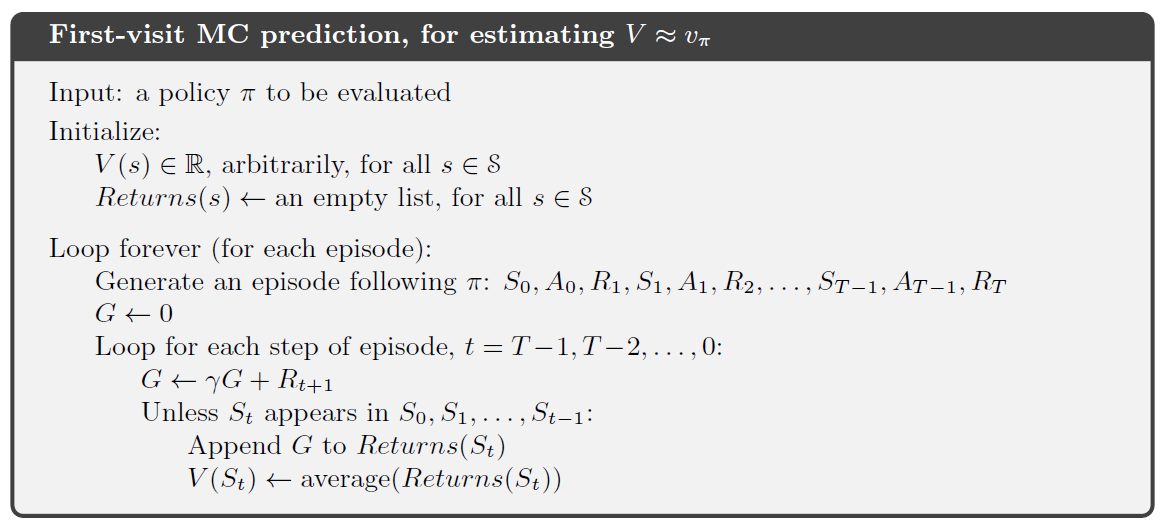

In [22]:
def MC_prediction(policy_fnc,step_size,num_episodes):
    V_S=defaultdict(float)
    num_visit=defaultdict(int)
    
    for episode in range(num_episodes):
        actions,states,rewards=[], [], []
        done=False
        initial_state=blackjack_env.reset()
        G=0
        
        # generating an episode
        while done==False:
            # select action according to policy
            action=policy_fnc(initial_state)
            # record action
            actions.append(action)
            # apply action to environment
            next_state,reward,done,info=blackjack_env.step(action)
            # recorde state
            states.append(initial_state)
            # record reward
            rewards.append(reward)
            # update agent state
            initial_state=next_state
        for t in range(len(states)-1,-1,-1):
            reward=rewards[t]
            state=states[t]
            G=G+reward
#             if state not in states[:t]:
            num_visit[state]+=1
            V_S[state]+=(G-V_S[state])/num_visit[state]
            # NewEstimate = OldEstimate+StepSize(Target-OldEstimate)
    return V_S                   

## predict value function with MC algorithm

In [180]:
predicted_value_func=MC_prediction(policy_func,None,500000)

## plot results

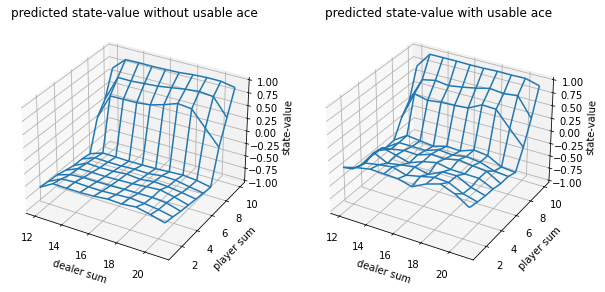

In [181]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)         
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
    X, Y = np.meshgrid(player_sum, dealer_show)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])   
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:    
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer sum')
        ax.set_zlabel('state-value')
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 10),subplot_kw={'projection': '3d'})
axes[0].set_title('predicted state-value without usable ace')
axes[1].set_title('predicted state-value with usable ace')
plot_blackjack(predicted_value_func, axes[0], axes[1])
# fig.savefig('predicted value function')

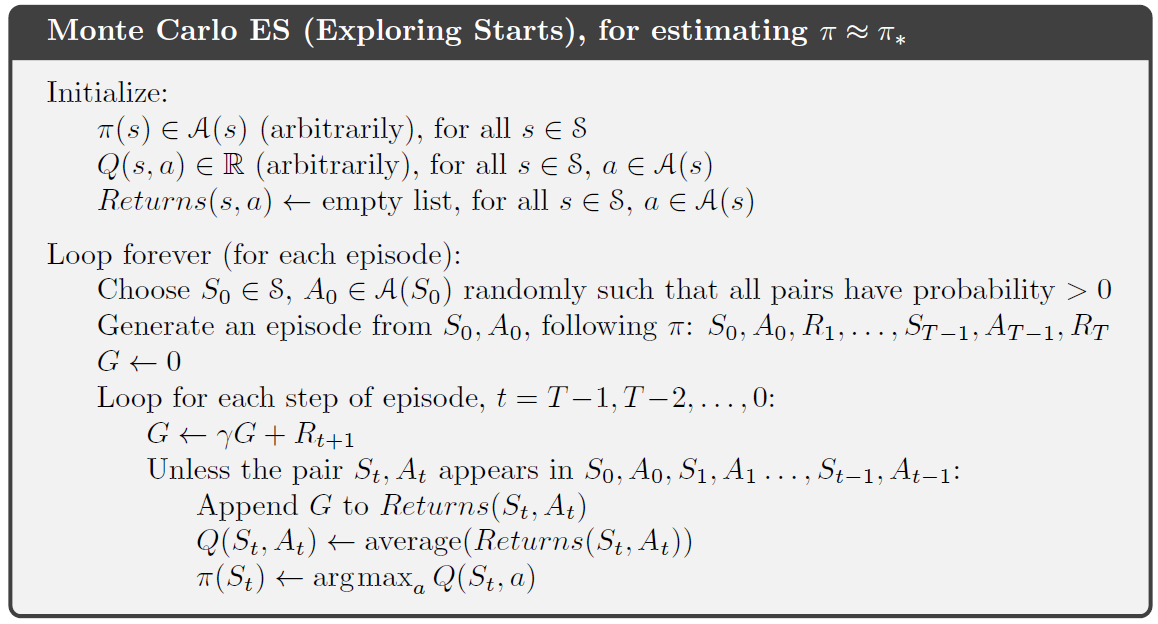

In [173]:
def MC_Control(step_size,num_episodes):
    epsilon=0.2
    Q_S_A=defaultdict(float)
    # initial policy selects draw in each state
    initial_policy_fnc=defaultdict(int)
    num_visit_state_action=defaultdict(int)
    for episode in range(num_episodes):
        actions,states,rewards=[], [], []
        done=False
        initial_state=blackjack_env.reset()
        G=0
        
        # generating an episode
        while done==False:
            # select action according to policy
            action=np.random.choice([0,1],1)[0] if epsilon>=np.random.rand(1)[0] else initial_policy_fnc[initial_state]
            # print(action)
            # record action
            actions.append(action)
            # apply action to environment
            next_state,reward,done,info=blackjack_env.step(action)
            # recorde state
            states.append(initial_state)
            # record reward
            rewards.append(reward)
            # update agent state
            initial_state=next_state
        for t in range(len(states)-1,-1,-1):
            reward_=rewards[t]
            state_=states[t]
            action_=actions[t]
            G=G+reward_
            #if state,action not in zip(states[:t],actions[:t]):
            num_visit_state_action[state_,action_]+=1
            # NewEstimate = OldEstimate+StepSize(Target-OldEstimate)
            Q_S_A[state_,action_]+=(G-Q_S_A[state_,action_])/num_visit_state_action[state_,action_]
            # policy improvment 
            optimal_action=np.argmax([Q_S_A[state_,0],Q_S_A[state_,1]])
            initial_policy_fnc[state_]=int(optimal_action)
                    


    return Q_S_A

In [174]:
Q_value,a=MC_Control(None,500000)

In [175]:
# calculate optimal value function
optimal_value_func=defaultdict(float)
i=0
for k ,v in Q_value.items():
    i+=1
    if i%2==0:
        optimal_value=max(Q_value[k[0],0],Q_value[k[0],1])
        optimal_value_func[k[0]]=optimal_value


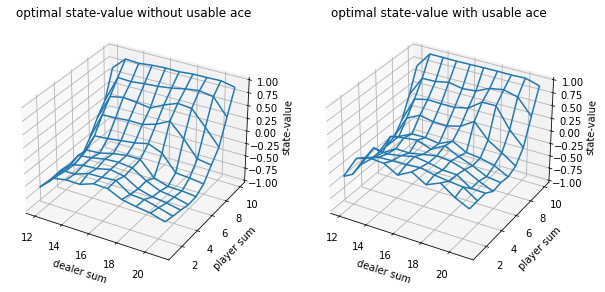

In [179]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)         
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]
                # print(state_values)
    X, Y = np.meshgrid(player_sum, dealer_show)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])   
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:    
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer sum')
        ax.set_zlabel('state-value')
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 10),subplot_kw={'projection': '3d'})
axes[0].set_title('optimal state-value without usable ace')
axes[1].set_title('optimal state-value with usable ace')
plot_blackjack(optimal_value_func, axes[0], axes[1])
fig.savefig('optinal value function')